<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 2539, '日付': '2021-09-03T08:00:00.000Z'},
 {'小計': 2362, '日付': '2021-09-04T08:00:00.000Z'},
 {'小計': 1853, '日付': '2021-09-05T08:00:00.000Z'},
 {'小計': 968, '日付': '2021-09-06T08:00:00.000Z'},
 {'小計': 1629, '日付': '2021-09-07T08:00:00.000Z'},
 {'小計': 1834, '日付': '2021-09-08T08:00:00.000Z'},
 {'小計': 1675, '日付': '2021-09-09T08:00:00.000Z'},
 {'小計': 1242, '日付': '2021-09-10T08:00:00.000Z'},
 {'小計': 1273, '日付': '2021-09-11T08:00:00.000Z'},
 {'小計': 1067, '日付': '2021-09-12T08:00:00.000Z'},
 {'小計': 611, '日付': '2021-09-13T08:00:00.000Z'},
 {'小計': 1004, '日付': '2021-09-14T08:00:00.000Z'},
 {'小計': 1052, '日付': '2021-09-15T08:00:00.000Z'},
 {'小計': 831, '日付': '2021-09-16T08:00:00.000Z'},
 {'小計': 782, '日付': '2021-09-17T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-09-13 17:00:00+09:00,455,0,611,2021-09-13 17:00:00+09:00
2021-09-14 17:00:00+09:00,455,0,1004,2021-09-14 17:00:00+09:00
2021-09-15 17:00:00+09:00,374,0,1052,2021-09-15 17:00:00+09:00
2021-09-16 17:00:00+09:00,327,0,831,2021-09-16 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-09-13 17:00:00+09:00,455,0,611,2021-09-13 17:00:00+09:00,503.857143,3527.0,0.0,0.0,1333.000000,9331.0
2021-09-14 17:00:00+09:00,455,0,1004,2021-09-14 17:00:00+09:00,480.714286,3365.0,0.0,0.0,1243.714286,8706.0
2021-09-15 17:00:00+09:00,374,0,1052,2021-09-15 17:00:00+09:00,456.857143,3198.0,0.0,0.0,1132.000000,7924.0
2021-09-16 17:00:00+09:00,327,0,831,2021-09-16 17:00:00+09:00,431.000000,3017.0,0.0,0.0,1011.428571,7080.0
2021-09-17 17:00:00+09:00,0,0,782,2021-09-17 17:00:00+09:00,356.857143,2498.0,0.0,0.0,945.714286,6620.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-09-03 17:00:00+09:00,761,0,2539,2021-09-03 17:00:00+09:00,1013.142857,7092.0,0.0,0.0,2898.857143,20292.0,'21w35,Fri
2021-09-04 17:00:00+09:00,850,0,2362,2021-09-04 17:00:00+09:00,943.142857,6602.0,0.0,0.0,2724.714286,19073.0,'21w35,Sat
2021-09-05 17:00:00+09:00,602,0,1853,2021-09-05 17:00:00+09:00,888.142857,6217.0,0.0,0.0,2549.285714,17845.0,'21w35,Sun
2021-09-06 17:00:00+09:00,742,0,968,2021-09-06 17:00:00+09:00,818.571429,5730.0,0.0,0.0,2414.000000,16898.0,'21w36,Mon
2021-09-07 17:00:00+09:00,617,0,1629,2021-09-07 17:00:00+09:00,764.714286,5353.0,0.0,0.0,2231.142857,15618.0,'21w36,Tue
2021-09-08 17:00:00+09:00,541,0,1834,2021-09-08 17:00:00+09:00,706.857143,4948.0,0.0,0.0,2040.571429,14284.0,'21w36,Wed
2021-09-09 17:00:00+09:00,508,0,1675,2021-09-09 17:00:00+09:00,660.142857,4621.0,0.0,0.0,1837.142857,12860.0,'21w36,Thu
2021-09-10 17:00:00+09:00,519,0,1242,2021-09-10 17:00:00+09:00,625.571429,4379.0,0.0,0.0,1651.857143,11563.0,'21w36,Fri
2021-09-11 17:00:00+09:00,506,0,1273,2021-09-11 17:00:00+09:00,576.428571,4035.0,0.0,0.0,1496.285714,10474.0,'21w36,Sat
2021-09-12 17:00:00+09:00,381,0,1067,2021-09-12 17:00:00+09:00,544.857143,3814.0,0.0,0.0,1384.000000,9688.0,'21w36,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-08-29 17:00:00+09:00,3784.000000,26488
2021-09-05 17:00:00+09:00,2549.285714,17845
2021-09-12 17:00:00+09:00,1384.000000,9688
2021-09-17 17:00:00+09:00,856.000000,4280
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-09-03 17:00:00+09:00,761,0,2539,2021-09-03 17:00:00+09:00,1013.142857,7092.0,0.0,0.0,2898.857143,20292.0,'21w35,Fri,NaN,NaN
2021-09-04 17:00:00+09:00,850,0,2362,2021-09-04 17:00:00+09:00,943.142857,6602.0,0.0,0.0,2724.714286,19073.0,'21w35,Sat,NaN,NaN
2021-09-05 17:00:00+09:00,602,0,1853,2021-09-05 17:00:00+09:00,888.142857,6217.0,0.0,0.0,2549.285714,17845.0,'21w35,Sun,2549.285714,17845.0
2021-09-06 17:00:00+09:00,742,0,968,2021-09-06 17:00:00+09:00,818.571429,5730.0,0.0,0.0,2414.000000,16898.0,'21w36,Mon,NaN,NaN
2021-09-07 17:00:00+09:00,617,0,1629,2021-09-07 17:00:00+09:00,764.714286,5353.0,0.0,0.0,2231.142857,15618.0,'21w36,Tue,NaN,NaN
2021-09-08 17:00:00+09:00,541,0,1834,2021-09-08 17:00:00+09:00,706.857143,4948.0,0.0,0.0,2040.571429,14284.0,'21w36,Wed,NaN,NaN
2021-09-09 17:00:00+09:00,508,0,1675,2021-09-09 17:00:00+09:00,660.142857,4621.0,0.0,0.0,1837.142857,12860.0,'21w36,Thu,NaN,NaN
2021-09-10 17:00:00+09:00,519,0,1242,2021-09-10 17:00:00+09:00,625.571429,4379.0,0.0,0.0,1651.857143,11563.0,'21w36,Fri,NaN,NaN
2021-09-11 17:00:00+09:00,506,0,1273,2021-09-11 17:00:00+09:00,576.428571,4035.0,0.0,0.0,1496.285714,10474.0,'21w36,Sat,NaN,NaN
2021-09-12 17:00:00+09:00,381,0,1067,2021-09-12 17:00:00+09:00,544.857143,3814.0,0.0,0.0,1384.000000,9688.0,'21w36,Sun,1384.000000,9688.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

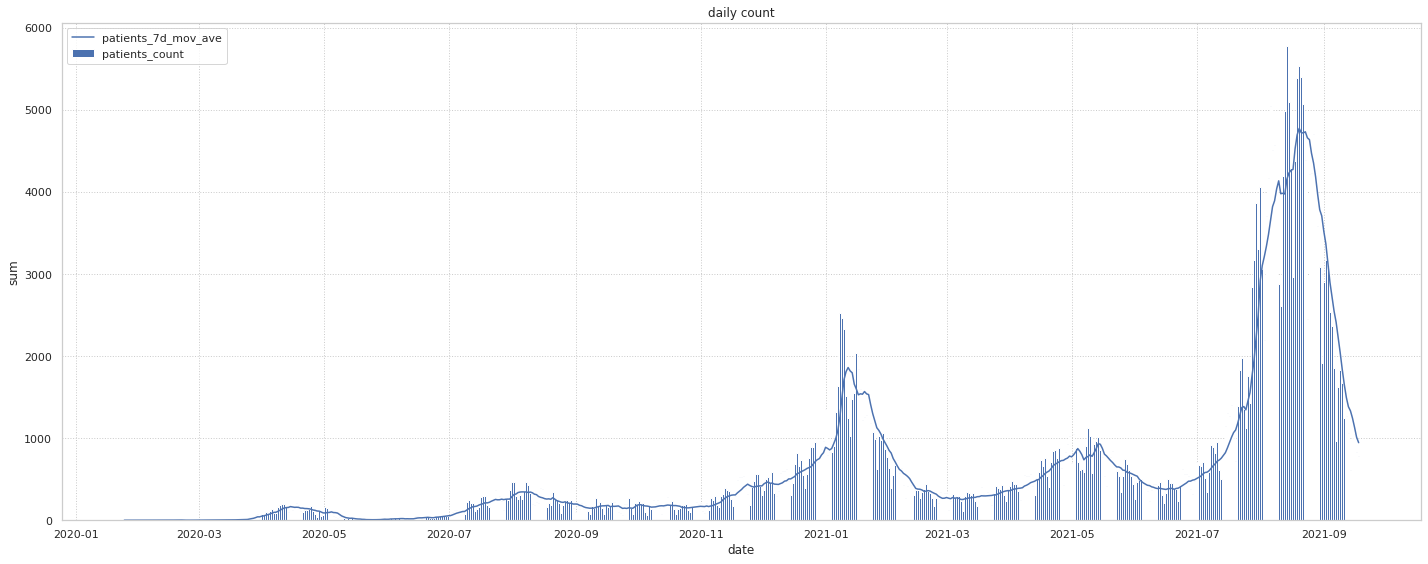

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
588,1.630656e+09,2021,9,3,1,0,0,0,0,0,0,588,0,514,761,1013.142857,7092.0,0,0.0,0.0,2539,2898.857143,20292.0
589,1.630742e+09,2021,9,4,0,0,1,0,0,0,0,589,0,515,850,943.142857,6602.0,0,0.0,0.0,2362,2724.714286,19073.0
590,1.630829e+09,2021,9,5,0,0,0,1,0,0,0,590,0,516,602,888.142857,6217.0,0,0.0,0.0,1853,2549.285714,17845.0
591,1.630915e+09,2021,9,6,0,1,0,0,0,0,0,591,0,517,742,818.571429,5730.0,0,0.0,0.0,968,2414.000000,16898.0
592,1.631002e+09,2021,9,7,0,0,0,0,0,1,0,592,0,518,617,764.714286,5353.0,0,0.0,0.0,1629,2231.142857,15618.0
593,1.631088e+09,2021,9,8,0,0,0,0,0,0,1,593,0,519,541,706.857143,4948.0,0,0.0,0.0,1834,2040.571429,14284.0
594,1.631174e+09,2021,9,9,0,0,0,0,1,0,0,594,0,520,508,660.142857,4621.0,0,0.0,0.0,1675,1837.142857,12860.0
595,1.631261e+09,2021,9,10,1,0,0,0,0,0,0,595,0,521,519,625.571429,4379.0,0,0.0,0.0,1242,1651.857143,11563.0
596,1.631347e+09,2021,9,11,0,0,1,0,0,0,0,596,0,522,506,576.428571,4035.0,0,0.0,0.0,1273,1496.285714,10474.0
597,1.631434e+09,2021,9,12,0,0,0,1,0,0,0,597,0,523,381,544.857143,3814.0,0,0.0,0.0,1067,1384.000000,9688.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            603 non-null    float64
 1   year                 603 non-null    int64  
 2   month                603 non-null    int64  
 3   day                  603 non-null    int64  
 4   Fri                  603 non-null    uint8  
 5   Mon                  603 non-null    uint8  
 6   Sat                  603 non-null    uint8  
 7   Sun                  603 non-null    uint8  
 8   Thu                  603 non-null    uint8  
 9   Tue                  603 non-null    uint8  
 10  Wed                  603 non-null    uint8  
 11  passed               603 non-null    int64  
 12  emergency            603 non-null    int64  
 13  em_passed            603 non-null    int64  
 14  contacts_count       603 non-null    int64  
 15  contacts_7d_mov_ave  603 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.030000e+02,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,1.605859e+09,2020.431177,5.993367,15.688226,0.144279,0.142620,0.142620,0.142620,0.142620,0.142620,0.142620,301.000000,0.081260,231.601990,702.195688,700.825594,4905.772803,611.142620,611.142620,4277.998342,614.532338,610.187467,4271.285240
std,1.505221e+07,0.495652,3.115169,8.839787,0.351664,0.349975,0.349975,0.349975,0.349975,0.349975,0.349975,174.215384,0.273461,167.356109,464.425414,452.285115,3166.005625,839.599766,762.836031,5339.852217,987.546757,953.629035,6675.420558
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.592856e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.500000,0.000000,76.500000,387.500000,388.500000,2719.500000,0.000000,0.000000,0.000000,100.500000,123.928571,867.500000
50%,1.605859e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,301.000000,0.000000,227.000000,544.000000,563.285714,3943.000000,0.000000,0.000000,0.000000,292.000000,289.000000,2023.000000
75%,1.618862e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,451.500000,0.000000,377.500000,836.000000,856.857143,5998.000000,1252.500000,1213.000000,8491.000000,620.000000,632.000000,4424.000000
max,1.631866e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,602.000000,1.000000,528.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.857783,0.201422,-0.012218,-1.169057e-18,-0.001172,-0.005858,-0.003515,0.005858,0.001172,0.003515,1.000000e+00,-0.346827,0.997244,-0.066014,-0.046296,-0.046292,-0.593466,-0.639367,-0.639367,0.607865,0.632632,0.632637
year,8.577834e-01,1.000000,-0.328425,-0.041681,4.646534e-03,-0.000778,-0.000778,-0.000778,-0.000778,-0.000778,-0.000778,8.577834e-01,-0.258930,0.868980,-0.116808,-0.096607,-0.096605,-0.634264,-0.698090,-0.698090,0.510654,0.533733,0.533735
month,2.014223e-01,-0.328425,1.000000,-0.035847,-9.739229e-03,-0.000654,-0.009796,-0.005225,0.013058,0.003917,0.008487,2.014223e-01,-0.141713,0.174879,0.103144,0.100780,0.100783,0.120040,0.158674,0.158674,0.141025,0.142757,0.142763
day,-1.221772e-02,-0.041681,-0.035847,1.000000,9.150587e-03,0.000436,0.005269,0.002584,-0.008692,-0.002785,-0.006007,-1.221772e-02,0.000190,-0.011583,-0.003653,-0.005043,-0.005046,0.011950,-0.000171,-0.000171,0.010860,0.005710,0.005705
Fri,-1.169057e-18,0.004647,-0.009739,0.009151,1.000000e+00,-0.167471,-0.167471,-0.167471,-0.167471,-0.167471,-0.167471,-1.541238e-18,-0.001203,0.000808,-0.022671,-0.005041,-0.005040,0.027751,-0.003244,-0.003244,0.030922,-0.000733,-0.000735
Mon,-1.171515e-03,-0.000778,-0.000654,0.000436,-1.674707e-01,1.000000,-0.166344,-0.166344,-0.166344,-0.166344,-0.166344,-1.171515e-03,0.000201,-0.001213,0.037857,0.000556,0.000557,0.122458,0.000543,0.000543,-0.096509,-0.000311,-0.000310
Sat,-5.857575e-03,-0.000778,-0.009796,0.005269,-1.674707e-01,-0.166344,1.000000,-0.166344,-0.166344,-0.166344,-0.166344,-5.857575e-03,0.000201,-0.005467,0.051510,-0.000697,-0.000696,-0.140291,0.000543,0.000543,0.030151,-0.001502,-0.001503
Sun,-3.514545e-03,-0.000778,-0.005225,0.002584,-1.674707e-01,-0.166344,-0.166344,1.000000,-0.166344,-0.166344,-0.166344,-3.514545e-03,0.000201,-0.003340,-0.023668,-0.000126,-0.000125,-0.129216,0.000543,0.000543,-0.023742,-0.000745,-0.000745
Thu,5.857575e-03,-0.000778,0.013058,-0.008692,-1.674707e-01,-0.166344,-0.166344,-0.166344,1.000000,-0.166344,-0.166344,5.857575e-03,0.000201,0.005225,-0.006335,0.002289,0.002290,0.036077,0.000543,0.000543,0.056225,0.001741,0.001742
Tue,1.171515e-03,-0.000778,0.003917,-0.002785,-1.674707e-01,-0.166344,-0.166344,-0.166344,-0.166344,1.000000,-0.166344,1.171515e-03,0.000201,0.000914,-0.023065,0.001238,0.001239,0.049153,0.000543,0.000543,-0.019628,0.000402,0.000403


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,1.631520e+09,0,1,0,0,0,0,0,598,0,524,455,0,611,1333.000000,9331.0
599,1.631606e+09,0,0,0,0,0,1,0,599,0,525,455,0,1004,1243.714286,8706.0
600,1.631693e+09,0,0,0,0,0,0,1,600,0,526,374,0,1052,1132.000000,7924.0
601,1.631779e+09,0,0,0,0,1,0,0,601,0,527,327,0,831,1011.428571,7080.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
598,1.631520e+09,598,0,611,1333.000000,9331.0
599,1.631606e+09,599,0,1004,1243.714286,8706.0
600,1.631693e+09,600,0,1052,1132.000000,7924.0
601,1.631779e+09,601,0,831,1011.428571,7080.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

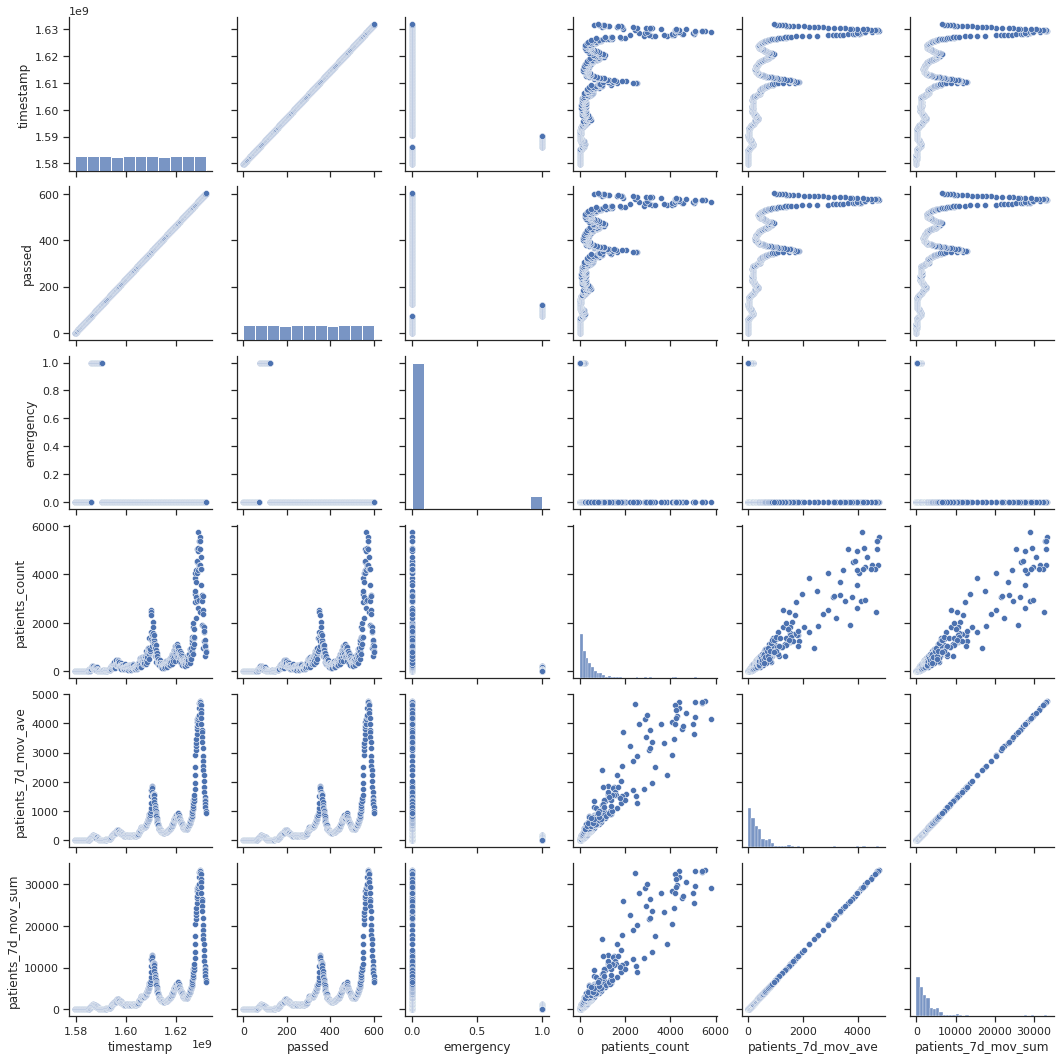

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
